In [2]:
!pip install contractions
#!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

     |████████████████████████████████| 266kB 26.5MB/s 
     |████████████████████████████████| 327kB 54.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85396 sha256=c5b689b6508c5ffb135c67d48d568e3bcd366426402456a25475e74129d71cc6
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import contractions
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential, load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
header = pd.read_csv('/content/drive/MyDrive/CA683/Copy of key.csv',sep='\t',header=None).transpose()[0].tolist()
test = pd.read_csv('/content/drive/MyDrive/CA683/Copy of test-balanced.csv',sep='\t',names = header)
train = pd.read_csv('/content/drive/MyDrive/CA683/Copy of train-balanced.csv',sep='\t',names = header)

In [ ]:
sws = set(stopwords.words("english"))
lemma = nltk.stem.WordNetLemmatizer()
stem = PorterStemmer()

In [ ]:
def clean_text(text):
  # Expand contractions
  text = contractions.fix(str(text))

  # Tokenisation
  text =  nltk.WordPunctTokenizer().tokenize(text)

  # Removing special characters and stopwords
  text = [ i for i in text if (i not in sws) and (i.isalpha())]

  # Lemmatisation
  text =  [lemma.lemmatize(w) for w in text]

  # Stemming
  text = [stem.stem(w) for w in text]
  return " ".join(text)
  #return text

def read_Glove_embeddings(filename):
  """
    Read in pre-trained word embedding vectors.
  """
  embedding_vector = {}
  with open(filename,'r',encoding='utf-8') as file:
    for row in tqdm(file):
        values = row.split(' ')
        word = values[0]
        weights = np.asarray([float(val) for val in values[1:]])
        embedding_vector[word] = weights
    print(f"Size of vocabulary in GloVe: {len(embedding_vector)}")
    return embedding_vector   

def creat_padded_sequence(train, test):
  """
    As the input are of various lengths, we need to first convert them 
    to sequence and pad those sequences to make them of the same length.
  """
  max_len = train.apply(lambda x: len(x)).max()
  tokenizer = text.Tokenizer()
  tokenizer.fit_on_texts(train)

  X_train_sequence = tokenizer.texts_to_sequences(train)
  X_test_sequence = tokenizer.texts_to_sequences(test)

  X_train_padded = sequence.pad_sequences(X_train_sequence, maxlen=max_len)
  X_test_padded = sequence.pad_sequences(X_test_sequence, maxlen=max_len)
  print('text example:', train[0])
  print('sequence of indices(before padding):', X_train_sequence[0])
  print('sequence of indices(after padding):', X_train_padded[0])
  return X_train_padded,X_test_padded, tokenizer.word_index

def creat_embedding_matrix(embedding_vector, word_index):
  """  
    Create embedding matrix from the embedding vector.
  """  
  embedding_dimension = 300
  vocabulary_length = len(word_index)+1
  embedding_matrix = np.zeros((vocabulary_length, embedding_dimension))

  for w, i in tqdm(word_index.items()):
    if i < vocabulary_length:
        vector = embedding_vector.get(w)
        if vector is not None:
            embedding_matrix[i] = vector

  return embedding_matrix

def plot_accuracy(history):
  """  
    Plot training and validation accuracy against epochs.
  """  
  epochs = len(history.history['loss'])
  plt.plot(range(epochs),history.history['val_accuracy'],label = 'Validation Accuracy')
  plt.plot(range(epochs),history.history['accuracy'],label = 'Training Accuracy')
  plt.title('Epochs vs Accuracy')
  plt.legend()
  plt.show()

def plot_loss(history):
  """  
    Plot training and validation loss against epochs.
  """ 
  epochs = len(history.history['loss'])
  plt.plot(range(epochs),history.history['val_loss'],label = 'Validation Loss')
  plt.plot(range(epochs),history.history['loss'],label = 'Training Loss')
  plt.title('Epochs vs Loss')
  plt.legend()
  plt.show()

def plot_confusion_matrix(confusion_matrix):
  group_names = ['True Negative','False Positive','False Neg','True Positive']
  group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion_matrix.flatten()/np.sum(confusion_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
train['cleaned_comment'] = [clean_text(i) for i in tqdm(train['comment'].values.tolist())]

In [ ]:
test['cleaned_comment'] = [clean_text(i) for i in tqdm(test['comment'].values.tolist())]

Save and reload data to prevent runtime crushing due data cleaning running out available RAM

In [ ]:
output = '/content/drive/MyDrive/'
train.to_pickle(output + 'cleaned_train.p')
test.to_pickle(output + 'cleaned_test.p')

In [6]:
output = '/content/drive/MyDrive/'
train = pd.read_pickle(output + 'cleaned_train.p')
test = pd.read_pickle(output + 'cleaned_test.p')
embedding_matrix = pd.read_pickle(output + 'embedding_matrix.p')

As comments come in various length, while neural networks require the size of each data point to be the same, so that we have to pad each data point to the maximum length among all data point. However, the length of the longest comments is 10000 words while 99.88\% of comments are less than 200 words. We need to remove those excessively long comments as it causes a burden to hardware, significantly increases the learning time, and degrades models performance.

In [8]:
train[train['cleaned_comment'].str.len() <= 200]['cleaned_comment'].count() / train['cleaned_comment'].count()

0.9988138413535069

In [9]:
test[test['cleaned_comment'].str.len() <= 200]['cleaned_comment'].count() / test['cleaned_comment'].count()

0.9987679247082764

In [ ]:
X_train = train[train['cleaned_comment'].str.len() <= 200]['cleaned_comment']
y_train = train[train['cleaned_comment'].str.len() <= 200]['label']
X_test = test[test['cleaned_comment'].str.len() <= 200]['cleaned_comment']
y_test = test[test['cleaned_comment'].str.len() <= 200]['label']

In [ ]:
subreddit_train = train[train['cleaned_comment'].str.len() <= 200]['subreddit']
subreddit_test = test[test['cleaned_comment'].str.len() <= 200]['subreddit']

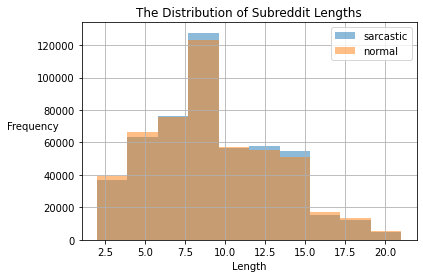

In [ ]:
train.loc[train['label'] == 1, 'subreddit'].str.len().hist(label='sarcastic', alpha=.5)
train.loc[train['label'] == 0, 'subreddit'].str.len().hist(label='normal', alpha=.5)
plt.title('The Distribution of Subreddit Lengths' )
plt.xlabel("Length")
plt.ylabel('Frequency',rotation=0)
plt.legend();

In [ ]:
X_train_padded, X_test_padded, word_index = creat_padded_sequence(X_train, X_test)

text example: NC NH
sequence of indices(before padding): [3808, 6172]
sequence of indices(after padding): [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  

In [ ]:
subreddit_train_padded, subreddit_test_padded, subreddit_word_index = creat_padded_sequence(subreddit_train, subreddit_test)

text example: politics
sequence of indices(before padding): [2]
sequence of indices(after padding): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]


In [ ]:
 X_train_combined = np.hstack([X_train_padded,subreddit_train_padded])
 X_test_combined = np.hstack([X_test_padded,subreddit_test_padded])

In [ ]:
#!unzip /content/glove.840B.300d.zip

In [ ]:
embedding_vector = read_Glove_embeddings('/content/glove.840B.300d.txt')

In [ ]:
embedding_matrix = creat_embedding_matrix(embedding_vector, word_index)

In [ ]:
pd.to_pickle(embedding_matrix, output + 'embedding_matrix.p')

In [ ]:
type(embedding_matrix)

numpy.ndarray

# Glove Word Embedding + GRU Model

## Feature: Comment

In [ ]:
embedding_dimension = embedding_matrix.shape[1]
vocabulary_length = len(word_index)+1
model = Sequential()
model.add(Embedding(vocabulary_length, embedding_dimension, trainable = False, weights=[embedding_matrix]))
model.add(GRU(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         35201400  
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 35,366,649
Trainable params: 165,249
Non-trainable params: 35,201,400
_________________________________________________________________
None


In [ ]:
history2 = model.fit(X_train_padded, np.asarray(y_train), validation_data=(X_test_padded, np.asarray(y_test)), batch_size = 256, epochs = 30)

Epoch 1/30
3944/3944 [==============================] - 204s 43ms/step - loss: 0.6149 - accuracy: 0.6555 - precision: 0.6719 - recall: 0.6091 - val_loss: 0.5767 - val_accuracy: 0.6930 - val_precision: 0.7203 - val_recall: 0.6316
Epoch 2/30
3944/3944 [==============================] - 168s 43ms/step - loss: 0.5743 - accuracy: 0.6959 - precision: 0.7198 - recall: 0.6416 - val_loss: 0.5670 - val_accuracy: 0.7022 - val_precision: 0.7368 - val_recall: 0.6296
Epoch 3/30
3944/3944 [==============================] - 167s 42ms/step - loss: 0.5635 - accuracy: 0.7043 - precision: 0.7279 - recall: 0.6543 - val_loss: 0.5623 - val_accuracy: 0.7060 - val_precision: 0.7407 - val_recall: 0.6344
Epoch 4/30
3944/3944 [==============================] - 166s 42ms/step - loss: 0.5563 - accuracy: 0.7110 - precision: 0.7339 - recall: 0.6620 - val_loss: 0.5601 - val_accuracy: 0.7077 - val_precision: 0.7349 - val_recall: 0.6504
Epoch 5/30
3944/3944 [==============================] - 167s 42ms/step - loss: 0.549

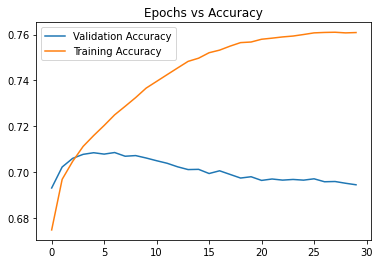

In [ ]:
plot_accuracy(history2)

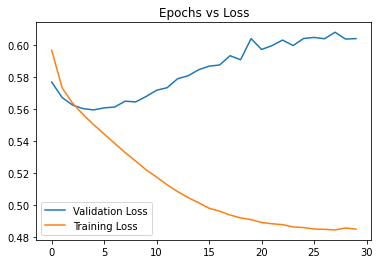

In [ ]:
plot_loss(history2)

In [ ]:
model.save('/content/drive/MyDrive/' + '1-cleanedcomments<200-10epochs.h5')

## Feature: Comment, Subreddit

In [ ]:
embedding_dimension = embedding_matrix.shape[1]
vocabulary_length = len(word_index)+1
model2 = Sequential()
model2.add(Embedding(vocabulary_length, embedding_dimension, trainable = False, weights=[embedding_matrix]))
model2.add(GRU(128, return_sequences=False))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation = 'sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         35201400  
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 35,366,649
Trainable params: 165,249
Non-trainable params: 35,201,400
_________________________________________________________________
None


In [ ]:
batch_size = 256
epochs  = 30
history = model2.fit(X_train_combined, np.asarray(y_train), validation_data=(X_test_combined, np.asarray(y_test)), batch_size = batch_size, epochs = epochs)

Epoch 1/30
3944/3944 [==============================] - 215s 46ms/step - loss: 0.6588 - accuracy: 0.5866 - precision: 0.5903 - recall: 0.5789 - val_loss: 0.5734 - val_accuracy: 0.6955 - val_precision: 0.7200 - val_recall: 0.6405
Epoch 2/30
3944/3944 [==============================] - 179s 45ms/step - loss: 0.5682 - accuracy: 0.7024 - precision: 0.7261 - recall: 0.6505 - val_loss: 0.5635 - val_accuracy: 0.7028 - val_precision: 0.6970 - val_recall: 0.7183
Epoch 3/30
3944/3944 [==============================] - 179s 45ms/step - loss: 0.5540 - accuracy: 0.7130 - precision: 0.7343 - recall: 0.6679 - val_loss: 0.5560 - val_accuracy: 0.7100 - val_precision: 0.7256 - val_recall: 0.6759
Epoch 4/30
3944/3944 [==============================] - 179s 45ms/step - loss: 0.5430 - accuracy: 0.7218 - precision: 0.7430 - recall: 0.6798 - val_loss: 0.5544 - val_accuracy: 0.7113 - val_precision: 0.7134 - val_recall: 0.7069
Epoch 5/30
3944/3944 [==============================] - 178s 45ms/step - loss: 0.533

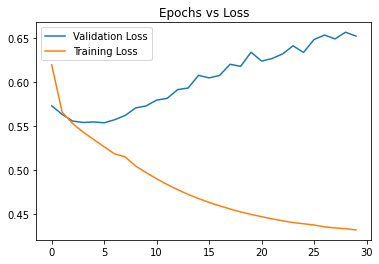

In [ ]:
plot_loss(history)

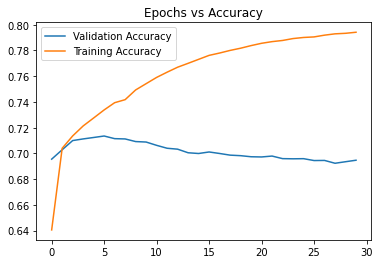

In [ ]:
plot_accuracy(history)

In [ ]:
y_predict = model2.predict(X_test_padded,batch_size)

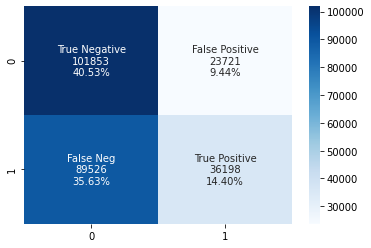

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_predict.round()))

In [ ]:
model2.save('/content/drive/MyDrive/' + '2-cleanedcomments<200+subreddits-30epochs.h5')

## Add 1 More Layer To GRU

In [ ]:
embedding_dimension = embedding_matrix.shape[1]
vocabulary_length = len(word_index)+1
model3 = Sequential()
model3.add(Embedding(vocabulary_length, embedding_dimension, trainable = False, weights=[embedding_matrix]))
model3.add(GRU(128,return_sequences= True, dropout = 0.25))
model3.add(GRU(128, dropout = 0.25))
model3.add(Dense(1, activation = 'sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         35201400  
_________________________________________________________________
gru_6 (GRU)                  (None, None, 128)         165120    
_________________________________________________________________
gru_7 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 35,465,721
Trainable params: 264,321
Non-trainable params: 35,201,400
_________________________________________________________________
None


In [ ]:
history3 = model3.fit(X_train_combined, np.asarray(y_train), validation_data=(X_test_combined, np.asarray(y_test)), batch_size = 256, epochs = 30)

Epoch 1/30
3944/3944 [==============================] - 283s 71ms/step - loss: 0.6311 - accuracy: 0.6270 - val_loss: 0.5762 - val_accuracy: 0.6963
Epoch 2/30
3944/3944 [==============================] - 286s 72ms/step - loss: 0.5726 - accuracy: 0.6972 - val_loss: 0.5638 - val_accuracy: 0.7042
Epoch 3/30
3944/3944 [==============================] - 280s 71ms/step - loss: 0.5605 - accuracy: 0.7069 - val_loss: 0.5541 - val_accuracy: 0.7116
Epoch 4/30
3944/3944 [==============================] - 275s 70ms/step - loss: 0.5526 - accuracy: 0.7127 - val_loss: 0.5515 - val_accuracy: 0.7140
Epoch 5/30
3944/3944 [==============================] - 277s 70ms/step - loss: 0.5480 - accuracy: 0.7171 - val_loss: 0.5529 - val_accuracy: 0.7145
Epoch 6/30
3944/3944 [==============================] - 278s 71ms/step - loss: 0.5437 - accuracy: 0.7200 - val_loss: 0.5522 - val_accuracy: 0.7154
Epoch 7/30
3944/3944 [==============================] - 278s 71ms/step - loss: 0.5394 - accuracy: 0.7236 - val_loss: 0

In [ ]:
plot_loss(history3)

In [ ]:
plot_accuracy(history3)

In [ ]:
model3.save('/content/drive/MyDrive/' + '3-cleanedcomments<200+subreddits+1layer-30epochs.h5')

## Add 2 More Layers To GRU

In [ ]:
embedding_dimension = embedding_matrix.shape[1]
vocabulary_length = len(word_index)+1
model4 = Sequential()
model4.add(Embedding(vocabulary_length, embedding_dimension, trainable = False, weights=[embedding_matrix]))
model4.add(GRU(128, return_sequences= True))
model4.add(Dropout(0.25))
model4.add(GRU(128, return_sequences= True))
model4.add(Dropout(0.25))
model4.add(GRU(128))
model4.add(Dropout(0.25))
model4.add(Dense(1, activation = 'sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model4.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         35201400  
_________________________________________________________________
gru (GRU)                    (None, None, 128)         165120    
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [ ]:
history4 = model4.fit(X_train_combined, np.asarray(y_train), validation_data=(X_test_combined, np.asarray(y_test)), batch_size = 256, epochs = 30)

Epoch 1/30
3944/3944 [==============================] - 409s 95ms/step - loss: 0.6350 - accuracy: 0.6192 - val_loss: 0.5681 - val_accuracy: 0.7006
Epoch 2/30
3944/3944 [==============================] - 376s 95ms/step - loss: 0.5608 - accuracy: 0.7075 - val_loss: 0.5564 - val_accuracy: 0.7098
Epoch 3/30
3944/3944 [==============================] - 377s 96ms/step - loss: 0.5457 - accuracy: 0.7202 - val_loss: 0.5545 - val_accuracy: 0.7122
Epoch 4/30
3944/3944 [==============================] - 377s 96ms/step - loss: 0.5333 - accuracy: 0.7286 - val_loss: 0.5517 - val_accuracy: 0.7146
Epoch 5/30
3944/3944 [==============================] - 376s 95ms/step - loss: 0.5242 - accuracy: 0.7356 - val_loss: 0.5538 - val_accuracy: 0.7142
Epoch 6/30
3944/3944 [==============================] - 376s 95ms/step - loss: 0.5144 - accuracy: 0.7433 - val_loss: 0.5541 - val_accuracy: 0.7132
Epoch 7/30
3944/3944 [==============================] - 374s 95ms/step - loss: 0.5041 - accuracy: 0.7494 - val_loss: 0

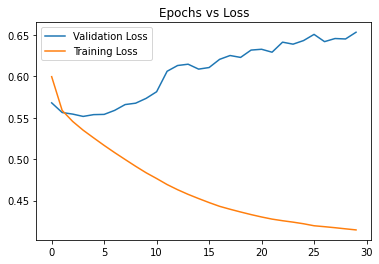

In [ ]:
plot_loss(history4)

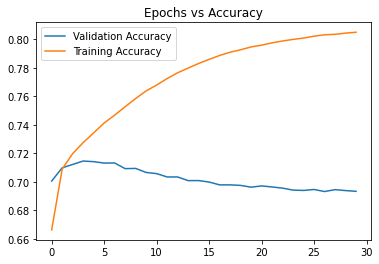

In [ ]:
plot_accuracy(history4)

In [ ]:
model4.save('/content/drive/MyDrive/' + '4-cleanedcomments<200+subreddits+2layers-30epochs.h5')